# P01 - Data Cleansing and evaluation

In [1]:
import pandas as pd
import numpy as np
import regex as re
import warnings
warnings.filterwarnings('ignore')
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import pickle

import matplotlib.pyplot as plt
import re

In [2]:
import seaborn as sns
from sklearn.model_selection import train_test_split

In [3]:
%config InlineBackend.figure_format = 'retina'

In [4]:
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import FunctionTransformer

from sklearn.compose import ColumnTransformer

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
import pandas as pd
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

# Read data set

In [7]:
file_path = "../DataSet/"
file_name = "exercise_40_train.csv"
df = pd.read_csv(file_path+file_name)

In [8]:
df.shape

(40000, 101)

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
y,40000.0,0.145075,0.352181,0.000000,0.000000,0.000000,0.000000,1.000000
x1,40000.0,2.999958,1.994490,-3.648431,1.592714,2.875892,4.270295,13.837591
x2,40000.0,20.004865,1.604291,13.714945,18.921388,20.005944,21.083465,27.086468
x4,40000.0,0.002950,1.462185,-5.137161,-1.026799,0.002263,1.043354,5.150153
x5,37572.0,0.005396,1.297952,-5.616412,-0.872354,0.008822,0.892467,5.698128
...,...,...,...,...,...,...,...,...
x95,27396.0,0.031886,1.823091,-6.885150,-1.190682,0.001523,1.248742,7.631773
x96,33362.0,10.525530,1.437581,8.210456,9.397548,10.358355,11.448559,18.725468
x97,40000.0,10.002814,1.986984,1.911272,8.665103,9.994318,11.342574,17.861580
x98,40000.0,0.497650,0.500001,0.000000,0.000000,0.000000,1.000000,1.000000


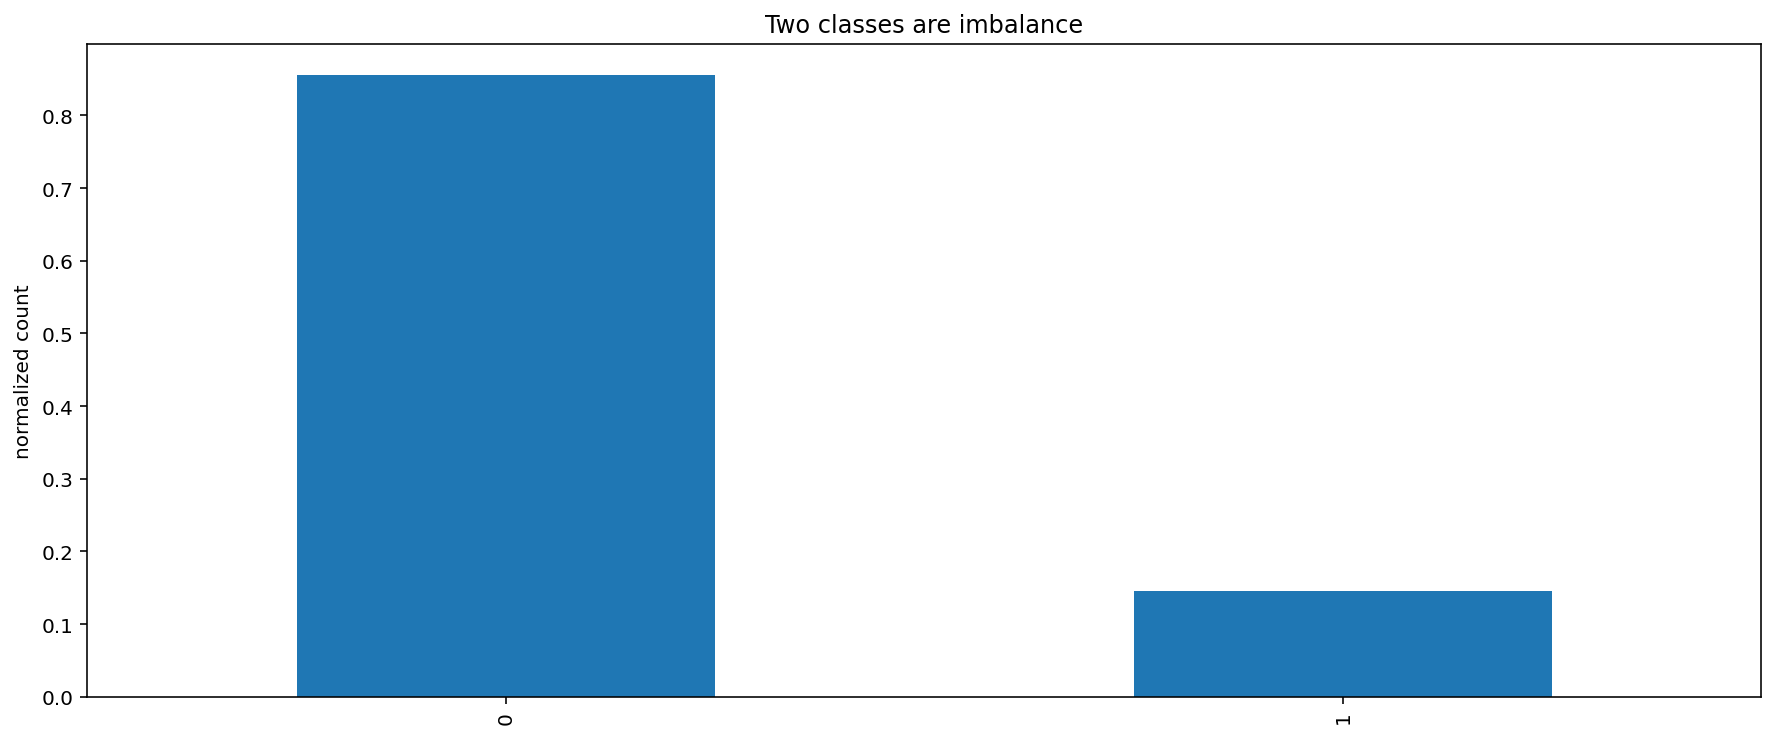

In [10]:
df['y'].value_counts(normalize=True).plot(kind='bar',figsize=(15,6))
plt.ylabel('normalized count')
plt.title('Two classes are imbalance')
plt.show()

# Data is imbalance

Check the column names and details as follow.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Columns: 101 entries, y to x100
dtypes: float64(86), int64(3), object(12)
memory usage: 30.8+ MB


In [12]:
df.head()

,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x91,x92,x93,x94,x95,x96,x97,x98,x99,x100
0,0,0.165254,18.060003,Wed,1.077380,-1.339233,-1.584341,0.0062%,0.220784,1.816481,...,-0.397427,0.909479,no,5.492487,NaN,10.255579,7.627730,0,yes,104.251338
1,1,2.441471,18.416307,Friday,1.482586,0.920817,-0.759931,0.0064%,1.192441,3.513950,...,0.656651,9.093466,no,3.346429,4.321172,NaN,10.505284,1,yes,101.230645
2,1,4.427278,19.188092,Thursday,0.145652,0.366093,0.709962,-8e-04%,0.952323,0.782974,...,2.059615,0.305170,no,4.456565,NaN,8.754572,7.810979,0,yes,109.345215
3,0,3.925235,19.901257,Tuesday,1.763602,-0.251926,-0.827461,-0.0057%,-0.520756,1.825586,...,0.899392,5.971782,no,4.100022,1.151085,NaN,9.178325,1,yes,103.021970
4,0,2.868802,22.202473,Sunday,3.405119,0.083162,1.381504,0.0109%,-0.732739,2.151990,...,3.003595,1.046096,yes,3.234033,2.074927,9.987006,11.702664,0,yes,92.925935


# Check out data for duplicates


In [13]:
# calculate duplicates
dups = df.duplicated()
# report if there are any duplicates
print(dups.any())
# # list all duplicate rows
# print(df[dups])

False


No duplicates found

In [14]:
df.dtypes.value_counts()

float64    86
object     12
int64       3
dtype: int64

there are 3 types of data in the data set

# Check out the object columns, number of uniques and number of NaNs

In [15]:
# columns_obj_dtype = []
# for col in df.columns:
#     if df[col].dtypes == 'object':
#         columns_obj_dtype.append(col)
              
df_categ = df.select_dtypes(include=['object'])
print(df_categ.columns)
columns_obj_dtype = df_categ.columns

# print('columns_obj_dtype = ', columns_obj_dtype)

print(100*'=')


number_of_Obj_cols_with_nan = 0
columns_obj_dtype_NaN = []


for col in columns_obj_dtype:
    if df_categ[col].isnull().sum() != 0:
        number_of_Obj_cols_with_nan = number_of_Obj_cols_with_nan + 1
        
        columns_obj_dtype_NaN.append(col)
        
        print('NaNs % in ', col, '=', (df_categ[col].isnull().sum())*100/(df_categ.shape[0]), '%',
              '\nNumber of uniqs =', df_categ[col].nunique(), '\n')
print('number_of_Obj_cols_with_nan ', number_of_Obj_cols_with_nan)

Index(['x3', 'x7', 'x19', 'x24', 'x31', 'x33', 'x39', 'x60', 'x65', 'x77',
       'x93', 'x99'],
      dtype='object')
NaNs % in  x24 = 9.64 % 
Number of uniqs = 2 

NaNs % in  x33 = 17.9275 % 
Number of uniqs = 51 

NaNs % in  x77 = 23.1425 % 
Number of uniqs = 7 

NaNs % in  x99 = 32.09 % 
Number of uniqs = 1 

number_of_Obj_cols_with_nan  4


---
we do have 4 columns containing NaN with obj dtype.

Visualize the columns at the following bar plot.

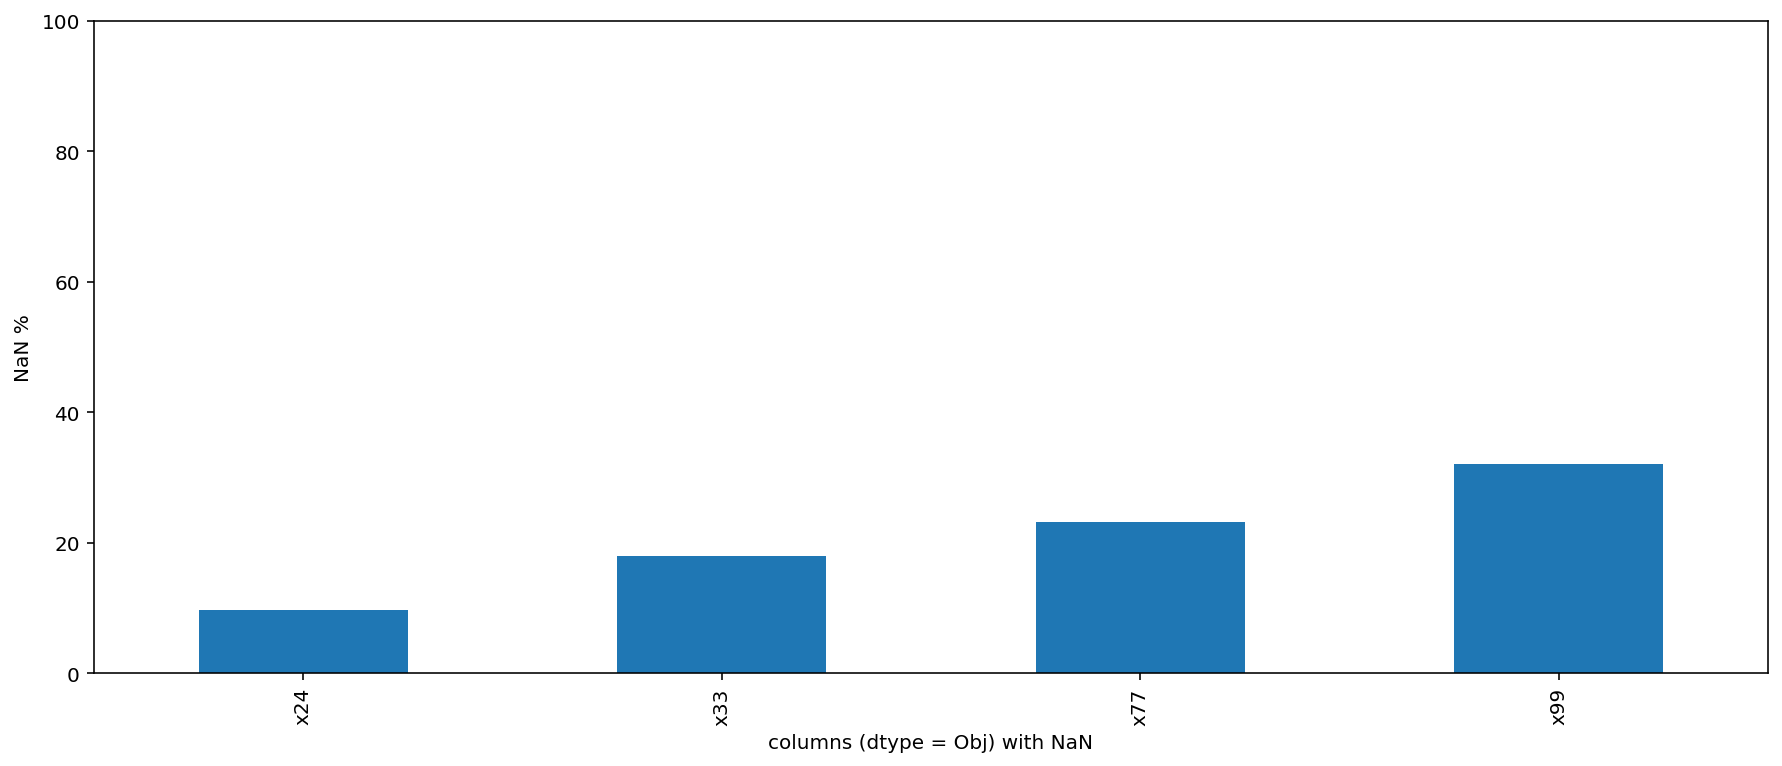

In [16]:
(df_categ[columns_obj_dtype_NaN].isnull().sum()*100/(df_categ.shape[0])).plot(kind='bar',figsize=(15,6))
plt.xlabel('columns (dtype = Obj) with NaN')
plt.ylabel('NaN %')
plt.ylim(0,100)
plt.show()

In [17]:
df_categ.nunique()

x3        14
x7       663
x19    40000
x24        2
x31        2
x33       51
x39        1
x60       12
x65        5
x77        7
x93        2
x99        1
dtype: int64

# Checking out categorical columns one by one and make sure about values and types and etc

check out the 'x3' column

In [18]:
df_categ['x3'].unique()

array(['Wed', 'Friday', 'Thursday', 'Tuesday', 'Sunday', 'Saturday',
       'Sat', 'Wednesday', 'Sun', 'Tue', 'Thur', 'Monday', 'Fri', 'Mon'],
      dtype=object)

In [19]:
# https://stackoverflow.com/questions/60237488/python-replace-only-exact-word-in-string
for i, string in enumerate(df_categ['x3'].values):
    df_categ['x3'].values[i] = re.sub(r'\bTue\b', 'Tuesday', string)
    
for i, string in enumerate(df_categ['x3'].values):
    df_categ['x3'].values[i] = re.sub(r'\bSun\b', 'Sunday', string)
    
for i, string in enumerate(df_categ['x3'].values):
    df_categ['x3'].values[i] = re.sub(r'\bSat\b', 'Saturday', string)
    
for i, string in enumerate(df_categ['x3'].values):
    df_categ['x3'].values[i] = re.sub(r'\bFri\b', 'Friday', string)
    
for i, string in enumerate(df_categ['x3'].values):
    df_categ['x3'].values[i] = re.sub(r'\bWed\b', 'Wednesday', string)
    
for i, string in enumerate(df_categ['x3'].values):
    df_categ['x3'].values[i] = re.sub(r'\bMon\b', 'Monday', string)
    
for i, string in enumerate(df_categ['x3'].values):
    df_categ['x3'].values[i] = re.sub(r'\bThur\b', 'Thursday', string)


In [20]:
df_categ['x3'].unique()

array(['Wednesday', 'Friday', 'Thursday', 'Tuesday', 'Sunday', 'Saturday',
       'Monday'], dtype=object)

## x3 is nominal categorical feature (needs OneHotEncoder transformer) plus some edits should be done using customized function.

check out the 'x7' column

In [21]:
df_categ['x7'].unique()

array(['0.0062%', '0.0064%', '-8e-04%', '-0.0057%', '0.0109%', '0.0079%',
       '0.0174%', '-0.0106%', '0.0032%', '0.0091%', '-0.0052%',
       '-0.0025%', '-0.0045%', '0.0068%', '-0.0137%', '-0.0014%',
       '-0.0013%', '0.0066%', '0.0097%', '-0.0086%', '0.0023%',
       '-0.0023%', '-0.0107%', '-0.0134%', '0.0058%', '-2e-04%',
       '-0.0033%', '-0.0172%', '-0.0026%', '-0.0118%', '0.0105%',
       '-0.0055%', '0.0095%', '0.0026%', '-0.0051%', '0.0054%',
       '-0.0167%', '0.0015%', '-0.0037%', '0.0011%', '-0.0097%',
       '-0.0016%', '-0.0155%', '0.015%', '-0.0032%', '2e-04%', '0.0122%',
       '0.0082%', '-0.0054%', '-0.0017%', '0.0013%', '0.0025%',
       '-0.0021%', '-0.017%', '-0.005%', '0.0014%', '-0.0103%', '-0.018%',
       '-0.0077%', '-0.0115%', '-0.0018%', '6e-04%', '-0.0169%',
       '0.0051%', '0.0093%', '-0.0043%', '0.0157%', '-0.0012%', '0.0056%',
       '-0.0035%', '0.005%', '0.0073%', '0.0127%', '0.0098%', '-0.0022%',
       '-0.0146%', '-0.0168%', '0.001%', '-0.

## x7 column: the % sign should be cleaned from strings and I need to change the dtype and introduce it as numeric feature.

In [22]:
df['x7'] = df['x7'].str.replace('%','')
print(df['x7'].dtypes)
df['x7'] = df['x7'].astype('float64')
df['x7'].dtypes


object


dtype('float64')

check out the 'x19' column

In [23]:
df_categ['x19'].unique()

array(['$-908.650758424405', '$-1864.9622875143', '$-543.187402955527',
       ..., '$834.95775080472', '$-48.1031003332715', '$96.0017151741518'],
      dtype=object)

## x19 column: the % sign should be cleaned from strings and I need to change the dtype and introduce it as numeric feature.

In [24]:
df_categ['x19'] = df_categ['x19'].str.replace('$','')
df_categ['x19'].dtypes
df_categ['x19'] = df_categ['x19'].astype('float64')
df_categ['x19'].dtypes



dtype('float64')

check out the 'x24' column

In [25]:
df_categ['x24'].unique()

array(['female', 'male', nan], dtype=object)

## x24 column: is nominal category and needs to be transformed using One Hot Encoding

check out the x31 column

In [26]:
df_categ['x31'].unique()

array(['no', 'yes'], dtype=object)

## x31 column: is nominal category and needs to be transformed using One Hot Encoding

check out the x33 column

In [27]:
df_categ['x33'].unique()

array(['Colorado', 'Tennessee', 'Texas', 'Minnesota', 'New York',
       'Florida', 'Nebraska', 'California', nan, 'North Dakota',
       'Arizona', 'Alabama', 'Ohio', 'Pennsylvania', 'Iowa', 'Indiana',
       'Vermont', 'Arkansas', 'Massachusetts', 'Illinois', 'Georgia',
       'West Virginia', 'Connecticut', 'Virginia', 'North Carolina',
       'Montana', 'New Mexico', 'New Hampshire', 'Michigan', 'DC',
       'Washington', 'Louisiana', 'Kentucky', 'Utah', 'Missouri',
       'Oregon', 'Oklahoma', 'Nevada', 'Wisconsin', 'New Jersey',
       'Maryland', 'Maine', 'Alaska', 'Idaho', 'Wyoming', 'Rhode Island',
       'South Dakota', 'Mississippi', 'Kansas', 'Delaware', 'Hawaii',
       'South Carolina'], dtype=object)

## x33 column: is nominal category and needs to be transformed using One Hot Encoding

check out the x39 column

In [28]:
df_categ['x39'].unique()

array(['5-10 miles'], dtype=object)

## Drop the column x39

check out the x60 column

In [29]:
df_categ['x60'].unique()

array(['August', 'April', 'September', 'January', 'December', 'March',
       'July', 'November', 'June', 'February', 'October', 'May'],
      dtype=object)

## x60 is nominal and OneHotEncoder should be used to transfer this column

check out the x65 column

In [30]:
df_categ['x65'].unique()

array(['farmers', 'allstate', 'geico', 'progressive', 'esurance'],
      dtype=object)

## x65 is nominal and OneHotEncoder should be used to transfer this column

check out the x77 column

In [31]:
df_categ['x77'].unique()

array(['mercedes', 'subaru', 'nissan', 'toyota', nan, 'chevrolet',
       'buick', 'ford'], dtype=object)

## x77 is nominal and OneHotEncoder should be used to transfer this column


check out the x93 column

In [32]:
df_categ['x93'].unique()

array(['no', 'yes'], dtype=object)

## x93 is nominal and OneHotEncoder should be used to transfer this column


check out the x99 (it has just one value - it is usedful)

In [33]:
df_categ['x99'].unique()

array(['yes', nan], dtype=object)

## X99 should be droped - it has just one category. The x24, x33, and x77 columns NaN values needs to be replaced by their mode.


# Recap#1 for categorical columns

* x3 is nominal categorical feature (needs OneHotEncoder transformer) and custom function edit is needed
* x7 column: the % sign should be cleaned from strings and I need to change the dtype and introduce it as numeric feature.
* x19 column: the % sign should be cleaned from strings and I need to change the dtype and introduce it as numeric feature.
* x24 column: is nominal category and needs to be transformed using One Hot Encoding
* x31 column: is nominal category and needs to be transformed using One Hot Encoding
* x33 column: is nominal category and needs to be transformed using One Hot Encoding
* x39 should be droped the column 
* x60 is nominal and OneHotEncoder should be used to transfer this column
* x65 is nominal and OneHotEncoder should be used to transfer this column
* x77 is nominal and OneHotEncoder should be used to transfer this column
* x93 is nominal and OneHotEncoder should be used to transfer this column
* X99 should be droped - it has just one category. 
* The x24, x33, and x77 columns NaN values needs to be replaced by their mode.


In [34]:
# OneHotEncoding columns
cols_to_be_OneHotEncoded = ['x3','x24','x31','x33',
                            'x60','x65','x77','x93']

cols_to_be_droped = ['x39','x99']

cols_to_be_imputed = ['x24','x33','x77']

cols_to_be_edited_custom_fun = ['x3', 'x7','x19']

# Custom transform

I need to use custom function transform


In [35]:
df['x3'].unique()

array(['Wed', 'Friday', 'Thursday', 'Tuesday', 'Sunday', 'Saturday',
       'Sat', 'Wednesday', 'Sun', 'Tue', 'Thur', 'Monday', 'Fri', 'Mon'],
      dtype=object)

In [36]:
# file_path = "../DataSet/"
# file_name = "exercise_40_train.csv"
# df = pd.read_csv(file_path+file_name)

# X = df[['x3']]
# print(X.shape)
# print(type(X))

# # extract the first letter from each string
# def fix_x3_wed(df):
    
#     return df.apply(lambda x: re.sub(r'\bWed\b', 'Wednesday', str(x)))

# fix_x3_wed = FunctionTransformer(fix_x3_wed)

# ct = make_column_transformer((fix_x3_wed, ['x3']))

# ct.fit_transform(X)

i get error here! cant make custom transformer! I move on.

```
ValueError: The output of the 'functiontransformer' transformer should be 2D (scipy matrix, array, or pandas DataFrame).


```

In [37]:
# for i, string in enumerate(df['x3'].values):
#     df['x3'].values[i] = re.sub(r'\bTue\b', 'Tuesday', string)
    
# for i, string in enumerate(df['x3'].values):
#     df['x3'].values[i] = re.sub(r'\bSun\b', 'Sunday', string)
    
# for i, string in enumerate(df['x3'].values):
#     df['x3'].values[i] = re.sub(r'\bSat\b', 'Saturday', string)
    
# for i, string in enumerate(df['x3'].values):
#     df['x3'].values[i] = re.sub(r'\bFri\b', 'Friday', string)
    
# for i, string in enumerate(df['x3'].values):
#     df['x3'].values[i] = re.sub(r'\bWed\b', 'Wednesday', string)
    
# for i, string in enumerate(df['x3'].values):
#     df['x3'].values[i] = re.sub(r'\bMon\b', 'Monday', string)
    
# for i, string in enumerate(df['x3'].values):
#     df['x3'].values[i] = re.sub(r'\bThur\b', 'Thursday', string)

# Categorical feature selection

let's score the features using select Kbest 

In [55]:
# logicbot 
# evaluation of a model fit using mutual information input features
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [135]:
# file_path = "../DataSet/"
# file_name = "exercise_40_train.csv"
# df = pd.read_csv(file_path+file_name)

In [110]:
# df_catego
dataset_features = df_catego.values
dataset_target = df_catego.values
# split into input (X) and output (y) variables
X = dataset_features[:, 2:] #exclude the $ column
y = dataset_target[:,0]

In [137]:
X[0]

array(['female', 'no', 'Colorado', '5-10 miles', 'August', 'farmers',
       'mercedes', 'no', 'yes'], dtype=object)

In [136]:
# imp = SimpleImputer(strategy="most_frequent")
# imp.fit_transform(X)

In [127]:

# load the dataset
def load_dataset():
    
    # load the dataset as a pandas DataFrame
    # df_catego
    dataset_features = df_catego.values
    dataset_target = df.values
    # split into input (X) and output (y) variables
    X = dataset_features[:, 2:]
    y = dataset_target[:,0]

    
    return X, y
 
# prepare input data
def prepare_inputs(X_train, X_test):
    
    imp = SimpleImputer(strategy="most_frequent")
    imp.fit(X_train)
    
    X_train_imp = imp.transform(X_train)
    X_test_imp = imp.transform(X_test)    
    
    
    oe = OrdinalEncoder()
    oe.fit(X_train_imp)
    
    X_train_enc = oe.transform(X_train_imp)
    X_test_enc = oe.transform(X_test_imp)
    
    return X_train_enc, X_test_enc
 
# prepare target
def prepare_targets(y_train, y_test):
    
    le = LabelEncoder()
    le.fit(y_train)
    
    y_train_enc = le.transform(y_train)
    y_test_enc = le.transform(y_test)
    
    return y_train_enc, y_test_enc
 
# feature selection
def select_features(X_train, y_train, X_test):
    fs = SelectKBest(score_func=mutual_info_classif, k=4)
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs
 

# load the dataset
X, y = load_dataset()

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

# prepare input data
X_train_enc, X_test_enc = prepare_inputs(X_train, X_test)

# prepare output data
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)

# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train_enc, y_train_enc, X_test_enc)

weights = {0:0.85, 1:0.14}
# fit the model
model = LogisticRegression(solver='lbfgs', class_weight=weights)
model.fit(X_train_fs, y_train_enc)

# evaluate the model
yhat = model.predict(X_test_fs)

# evaluate predictions
accuracy = accuracy_score(y_test_enc, yhat)
print('Accuracy: %.2f' % (accuracy*100))

Accuracy: 85.65


In [122]:
from matplotlib import pyplot

Feature 0: 0.000080
Feature 1: 0.006212
Feature 2: 0.008428
Feature 3: 0.002477
Feature 4: 0.001000
Feature 5: 0.000000
Feature 6: 0.000000
Feature 7: 0.001569
Feature 8: 0.000000


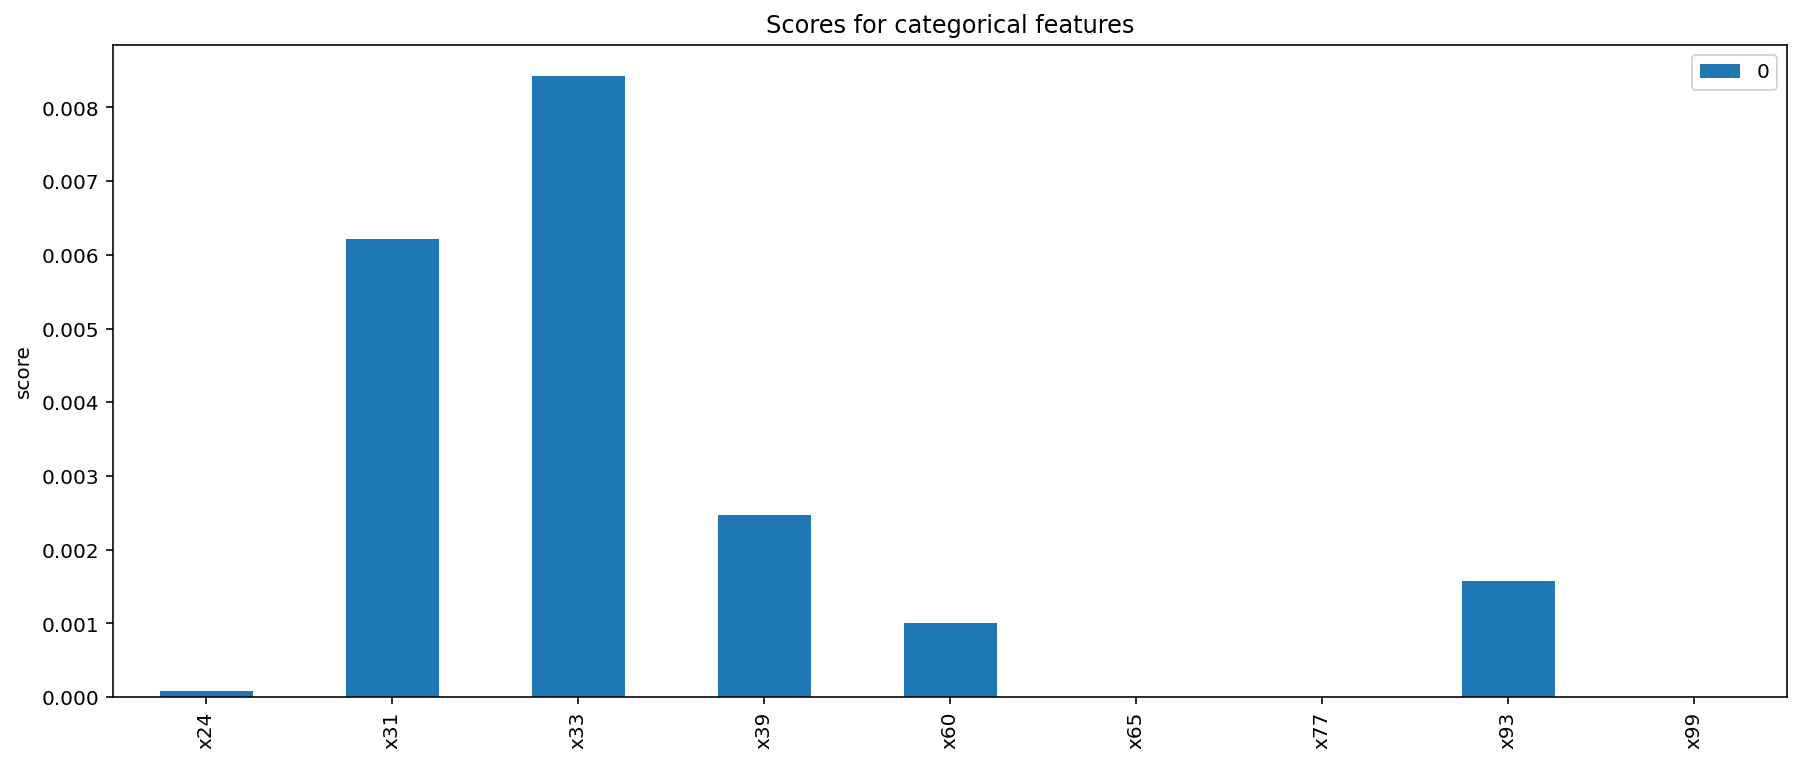

In [218]:
# load the dataset
X, y = load_dataset()

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

# prepare input data
X_train_enc, X_test_enc = prepare_inputs(X_train, X_test)
# prepare output data
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)
# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train_enc, y_train_enc, X_test_enc)
# what are scores for the features
scr_list = []
for i in range(len(fs.scores_)):
    scr_list.append(fs.scores_[i])
    print('Feature %d: %f' % (i, fs.scores_[i]))
    
    

# plot the scores
scr_list_pd = pd.DataFrame(scr_list)
# print(scr_list_pd)

scr_list_pd = scr_list_pd.rename(index={0: 'x24',1:'x31', 2:'x33', 3:'x39', 4:'x60',
                                  5:'x65', 6:'x77', 7:'x93', 8:'x99'})


scr_list_pd.plot(kind='bar', figsize=(15,6), label=False)
plt.ylabel('score')
plt.title('Scores for categorical features')
plt.show()

In [214]:
print(X[0])

print(df_catego.columns)

df_catego.head(2)

['female' 'no' 'Colorado' '5-10 miles' 'August' 'farmers' 'mercedes' 'no'
 'yes']
Index(['x3', 'x19', 'x24', 'x31', 'x33', 'x39', 'x60', 'x65', 'x77', 'x93',
       'x99'],
      dtype='object')


,x3,x19,x24,x31,x33,x39,x60,x65,x77,x93,x99
0,Wed,$-908.650758424405,female,no,Colorado,5-10 miles,August,farmers,mercedes,no,yes
1,Friday,$-1864.9622875143,male,no,Tennessee,5-10 miles,April,allstate,mercedes,no,yes


In [240]:
X[0]

array(['female', 'no', 'Colorado', '5-10 miles', 'August', 'farmers',
       'mercedes', 'no', 'yes'], dtype=object)

Using column transform and preforming two transformation on one column

In [236]:
two_transformer_pipe = make_pipeline(SimpleImputer(strategy="most_frequent"), 
                                     OneHotEncoder())

col_transform = ColumnTransformer(transformers=[("two_transformer_pipe", 
                                                 two_transformer_pipe, 
                                                 df_catego.columns)])


In [264]:
# col_transform.fit_transform(X)

In [237]:
# a = pd.DataFrame(col_transform.fit_transform(X.head()))

In [42]:
df['y'].value_counts(normalize=True)

0    0.854925
1    0.145075
Name: y, dtype: float64

In [265]:
from sklearn.model_selection import RepeatedStratifiedKFold

weights = {0:0.85, 1:0.14}

# model = LogisticRegression(solver='saga', class_weight=weights)
# # # define evaluation procedure
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# # # evaluate model
# cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)

# logreg = LogisticRegression(solver='sag',class_weight=weights)
# pipe = make_pipeline(col_transform, logreg)
# cross_val_score(pipe, X, y, cv=cv, scoring='roc_auc', n_jobs=-1)

In [246]:
X = df[['x3', 'x24', 'x31', 'x33', 'x60', 'x65', 'x77', 'x93']]

y = df['y']

x_3_trans_pipe = make_pipeline(SimpleImputer(strategy="most_frequent"), OneHotEncoder())

col_transform  = make_column_transformer((x_3_trans_pipe, ['x3', 'x24', 'x31','x33', 'x60', 'x65','x77', 'x93']))

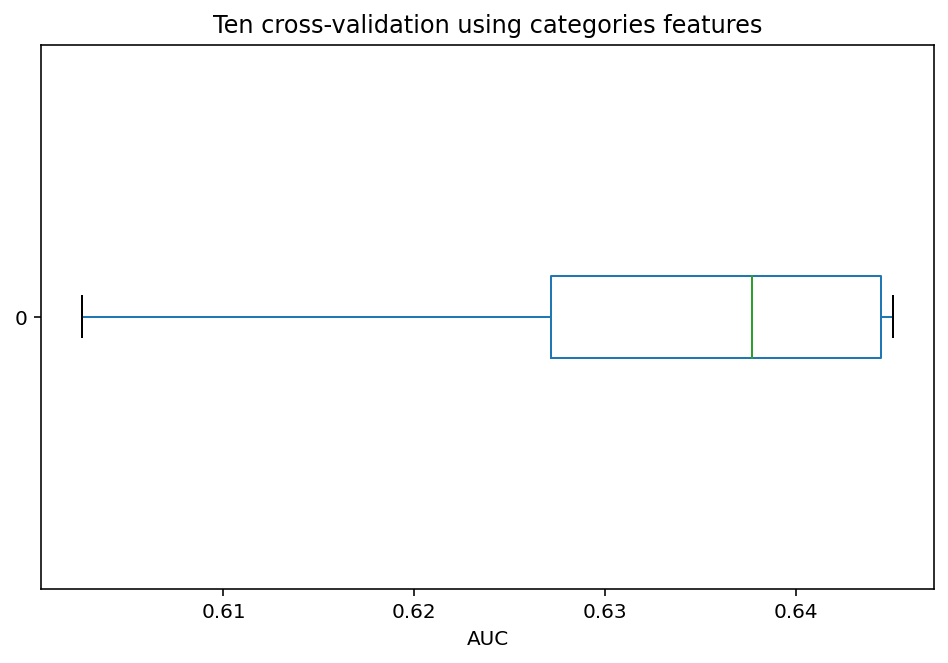

In [263]:
weights = {0:0.85, 1:0.14}
logreg = LogisticRegression(solver='sag',class_weight=weights)
pipe2 = make_pipeline(col_transform, logreg)
scor = cross_val_score(pipe2, X, y, cv=10, scoring='roc_auc')

scor = pd.DataFrame(scor)
# plt.ylim(0,1)
scor.plot(kind='box', vert=False, figsize=(8,5))
plt.xlabel('AUC')
plt.title('Ten cross-validation using categories features')
plt.show()

# Grid search

In [53]:
# https://machinelearningmastery.com/modeling-pipeline-optimization-with-scikit-learn/

In [54]:
pipe = Pipeline([
('scaler', StandardScaler()),
('selector', VarianceThreshold()),
('classifier', KNeighborsClassifier())
])

NameError: name 'Pipeline' is not defined

In [ ]:
pipe.fit(X_train, y_train)

print('Training set score: ' + str(pipe.score(X_train,y_train)))
print('Test set score: ' + str(pipe.score(X_test,y_test)))

In [ ]:

parameters = {'scaler': [StandardScaler(), MinMaxScaler(),
    Normalizer(), MaxAbsScaler()],
    'selector__threshold': [0, 0.001, 0.01],
    'classifier__n_neighbors': [1, 3, 5, 7, 10],
    'classifier__p': [1, 2],
    'classifier__leaf_size': [1, 5, 10, 15]
}

In [ ]:

grid = GridSearchCV(pipe, parameters, cv=2).fit(X_train, y_train)
print('Training set score: ' + str(grid.score(X_train, y_train)))
print('Test set score: ' + str(grid.score(X_test, y_test)))

In [ ]:

# Access the best set of parameters
best_params = grid.best_params_
print(best_params)
# Stores the optimum model in best_pipe
best_pipe = grid.best_estimator_
print(best_pipe)